# Проект № 2.1
## Подготовка аналитического отчета с использованием SQL-запросов

Задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

In [1]:
# Вызов необходимых библиотек
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sb

**1. Есть ли зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.**

In [40]:
# Составим запрос, который вернет типы perfomance score

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)

cursor = conn.cursor()
sql_str = 'SELECT DISTINCT "Performance Score" FROM hr_dataset ORDER BY "Performance Score";'
cursor.execute(sql_str)
performance_score_unique = cursor.fetchall()

cursor.close()

# Сохраним типы perfomance score в отдельный список, используем при построении графика (подпись осей)
performance_score_unique_list = [] 
for item in performance_score_unique:
    performance_score_unique_list.append(item[0])

In [20]:
# Составим запрос, в котором посчитаем сколько человек в каждой категории "Performance Score" закреплены за 'Manager Name'
# в абсолютных единицах


sql_str = '''SELECT 
                    "Manager Name" AS manager_name, 
                    "Performance Score" AS performance_score, 
                    COUNT("Performance Score") as performance_score_counter
            FROM hr_dataset 
            GROUP BY manager_name, performance_score
            ORDER BY manager_name, performance_score;'''
# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
performance_score_unique_df = pd.read_sql_query(sql_str, conn)

# Сгруппируем датафрейм повторно для удобного построения графика
performance_score_unique_df = performance_score_unique_df.groupby('manager_name')
# Извлечем фамилии-ключи группы
manager_name_keys = list(performance_score_unique_df.groups.keys())

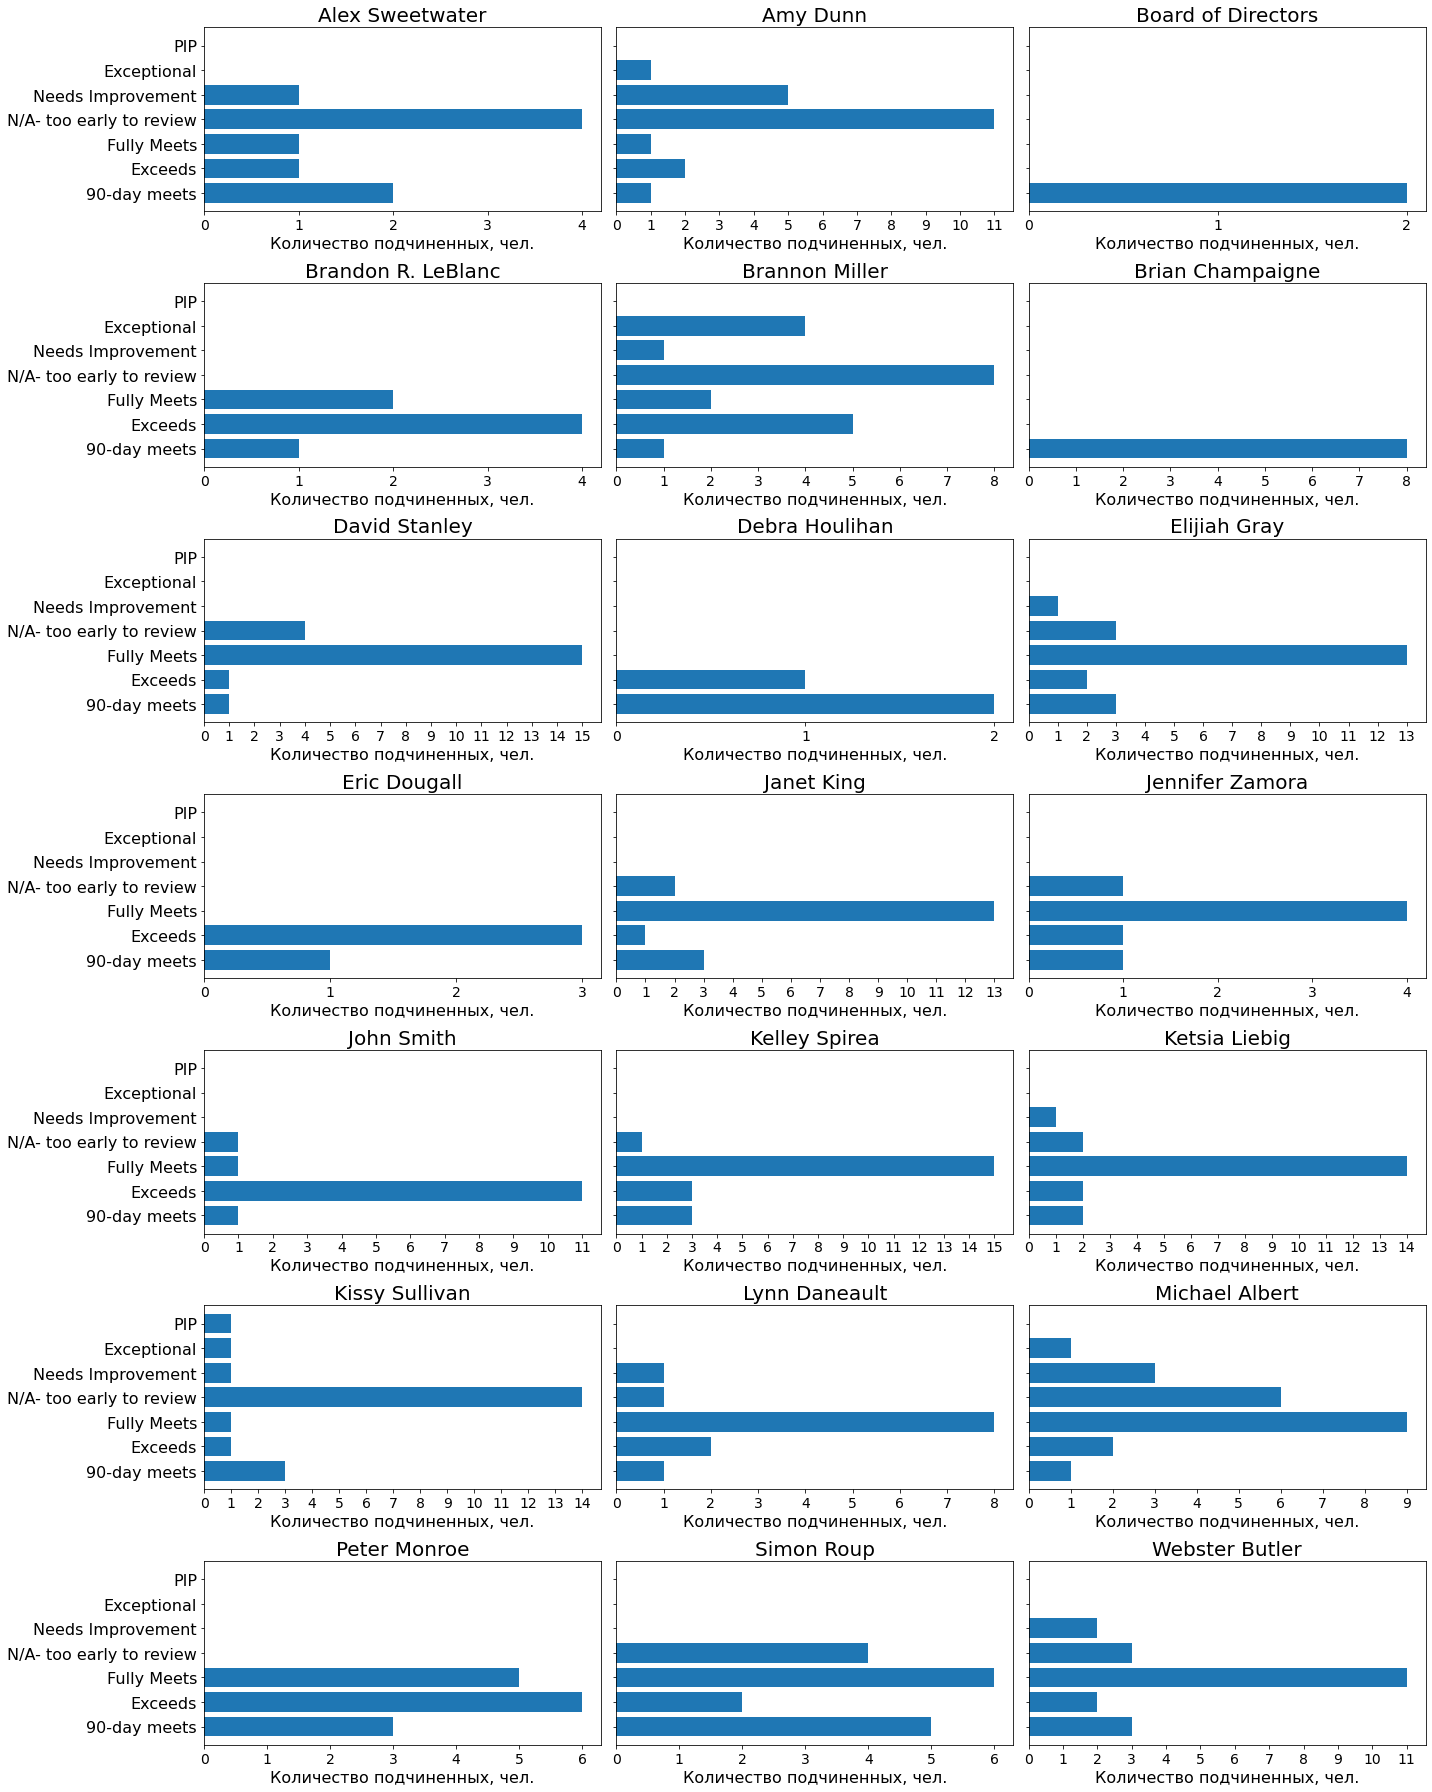

In [21]:
# Построение графика
fig, ax = plt.subplots(7, 3, figsize = (20,25), sharey=True)
for ax, manager in zip(ax.ravel(), manager_name_keys):
    current_group = performance_score_unique_df.get_group(manager)
    ax.barh(current_group['performance_score'], current_group['performance_score_counter'])
    ax.set_title(manager, fontsize=20)
    ax.set_xlabel('Количество подчиненных, чел.', fontsize=16)
    # Ось "х"
    xticks=[i for i in range(0, max(current_group['performance_score_counter']) + 1)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=14)
    
    # Ось "у". Ранее мы сформировали лист с performance_score, он пригодится для обозначения осей
    yticks = performance_score_unique_list
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=16)
    
    plt.tight_layout()
plt.show()

Выводы:
* Менеджеры "Board of Directors" и "Brian Champaigne" имеют 2 и 8 подчиненных в единственной категории **90-days meets**.
* У менеджеров "David Stanley", "Janet King", "Kelley Spirea", "Ketsia Liebig", "Lynn Daneault", "Webster Butler" подавляющее число подчиненных относятся к категории **Fully Meets**. Возможно, стоит сделать вывод, что данные менеджеры хорошо стравляются со своей работой в плане подготовки кадров. Стоит рассмотреть поощрение данных менеджеров.
* У менеджеров "Brandon R. LeBlanc", "Eric Dougall", "John Smith" подавляющее число подчиненных относятся к категории **Exceeds**. Возможно, стоит сделать вывод, что данные менеджеры хорошо стравляются со своей работой в плане подготовки кадров, но необходимо рассмотреть возможность продвижения по карьерной лестнице для их подчиненных.
* У менеджера "Kissy Sullivan" большиство подчиненных находятся в категории **N/A - too early to review**. Необходимо обратить внимание на работу данного менеждера и выявить причину, из-за которой подчиненные не дотягивают до уровня *Fully Meets* или выше.

**2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.**

In [5]:
# Составим запрос, выберающий столбцы по "maritalstatusid" и "Days Employed"
sql_str = '''SELECT 
                    maritalstatusid AS marital_status_id, 
                    "Days Employed" AS days_employed
            FROM hr_dataset
            ORDER BY marital_status_id;'''
# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
marital_status_id_df = pd.read_sql_query(sql_str, conn)

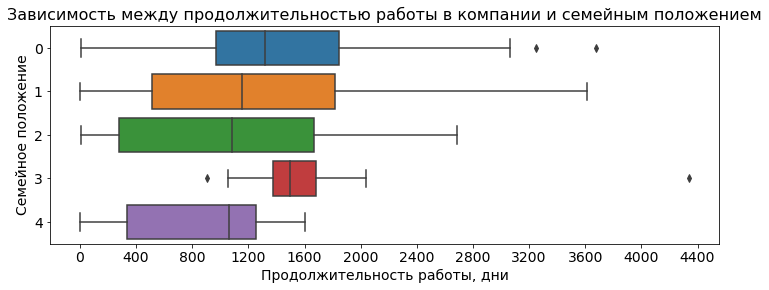

In [6]:
# Построим boxplot, отражающий распределение данных
plt.figure(figsize=(12,4))
plt.title("Зависимость между продолжительностью работы в компании и семейным положением", fontsize=16)
plt.xlabel('Продолжительность работы, дни', fontsize=14)
plt.ylabel('Семейное положение', fontsize=14)
plt.xticks(range(0, max(marital_status_id_df['days_employed'] + 400), 400))
plt.tick_params(labelsize=14)
sb.boxplot(x='days_employed', y='marital_status_id', data=marital_status_id_df, orient='h')\
    .set(ylabel='Семейное положение', xlabel='Продолжительность работы, дни')
plt.show()

In [7]:
# Дополнительно составим запрос, в котором посчитаем, сколько людей работают с определенным "maritalstatusid"

cursor = conn.cursor()
sql_str = '''SELECT 
                    maritalstatusid AS marital_status_id, COUNT("maritalstatusid")
            FROM hr_dataset
            GROUP BY marital_status_id
            ORDER BY marital_status_id;'''

cursor.execute(sql_str)
marital_status_id_counter = cursor.fetchall()
cursor.close()

for i in marital_status_id_counter:
    print('С семейным положением {} работают {} сотрудников.'.format(i[0],i[1]))

С семейным положением 0 работают 137 сотрудников.
С семейным положением 1 работают 123 сотрудников.
С семейным положением 2 работают 30 сотрудников.
С семейным положением 3 работают 12 сотрудников.
С семейным положением 4 работают 8 сотрудников.


Выводы:
* С семейным положением "3" присутствует 12 сотрудников. Эта категория имеет самое большое медианное значение из всех групп.
* С семейным положением "0" присутствует 137 сотрудников. Эта категория самая многочисленная и занимает 2 место (> 1300 дней) по величине медианного значения из всех групп. 
* С семейным положением "1" присутствует 123 сотрудника. Эта категория 2 по многочисленности и занимает 3 место (~ 1100 дней) по величине медианного значения из всех групп. Также у данной группы достаточно маленькое значение 25%-го квартиля - это говорит о том, что в компании работают много новых сотрудников, а значит, либо в компании расширился штат, либо высокая текучка кадров. Стоит обратить на это внимание и придумать как убедить сотрудников в данной группе оставаться в компании дольше.
* Также стоит обратить внимание на значение 25%-го квартиля в группах с семейным положением "2" и "4", оно достаточно сильно отличается от медианы. Но в компании с данными статусами работают 30 и 8 сотрудников соответственно, возможно, нет необходимости заострять на них внимание.

**3. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.**

In [8]:
# Составим запрос, в котором выберем столбцы по "age" и "Days Employed"

sql_str = '''SELECT age, "Days Employed" AS days_employed
            FROM hr_dataset;'''
# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
age_df = pd.read_sql_query(sql_str, conn)

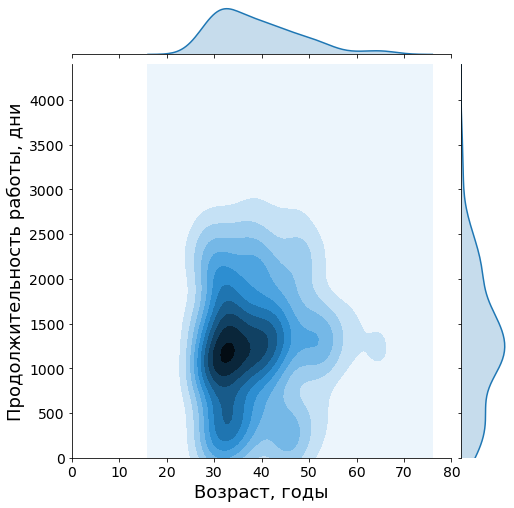

In [9]:
# Построим график, отражающий зависимость продолжительности работы от восзраста сотрудника
p = sb.jointplot(x="age", y="days_employed", data=age_df, kind='kde', height=7, ratio=7, xlim=[0,80] , ylim=[0,4400])\
        .set_axis_labels("Возраст, годы", "Продолжительность работы, дни", size=18)
p.ax_joint.tick_params(labelsize=14)
plt.show()

Вывод: Большиство струдников работают **~ 3,5 года (~ 1200 дней)** и им **30-35 лет**.

**4. Есть ли зависимость между продолжительностью работы в компании и полом сотрудника?**

In [41]:
# Составим запрос, в котором посчитаем, сколько процентов мужчин и женщин работает в компании

cursor = conn.cursor()
sql_str = '''SELECT 100 * SUM((Sex = 'Male')::INT) / COUNT(Sex) percent_m,
       100 * SUM((Sex = 'Female')::INT) / COUNT(Sex) percent_f
       FROM hr_dataset;'''

# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
gender_counter = pd.read_sql_query(sql_str, conn)

In [42]:
gender_counter

,percent_m,percent_f
0,42,57


In [31]:
gender_counter.iloc[0]['percent_m']

42

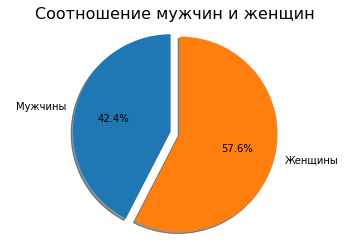

In [43]:
labels = 'Мужчины', 'Женщины'
sizes = [gender_counter.iloc[0]['percent_m'], gender_counter.iloc[0]['percent_f']]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title("Соотношение мужчин и женщин", fontsize=16)
plt.show()

In [12]:
# Составим запрос, в котором выберем столбцы по "genderid" и "Days Employed"

sql_str = '''SELECT sex AS gender, "Days Employed" AS days_employed
            FROM hr_dataset
            ORDER BY gender;'''
# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
gender_df = pd.read_sql_query(sql_str, conn)

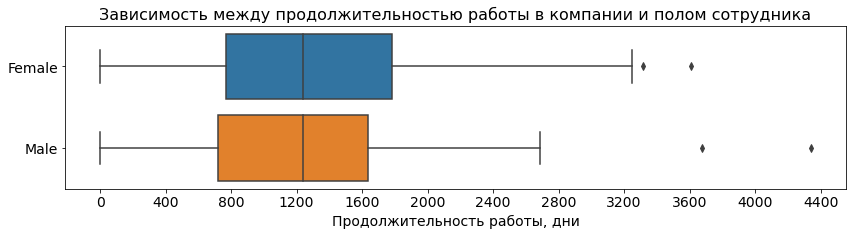

In [13]:
# Построим boxplot, отражающий распределение данных
plt.figure(figsize=(14,3))
plt.title("Зависимость между продолжительностью работы в компании и полом сотрудника", fontsize=16)
plt.xlabel('Продолжительность работы, дни', fontsize=14)
plt.xticks(range(0, max(gender_df['days_employed'] + 400), 400))
plt.tick_params(labelsize=14)
sb.boxplot(x='days_employed', y='gender', data=gender_df, orient='h')\
    .set(ylabel=None, xlabel='Продолжительность работы, дни')
plt.show()

Вывод:
* Пол сотрудника на продолжительность работы в компании не влияет.
* Женщин в компании больше.

**5. Есть ли зависимость между расой и уровнем заработной платы?**

In [11]:
# Предварительно составим запрос, в котором посчитаем, сколько представителей определенной расы работают в продакшене

cursor = conn.cursor()
sql_str = '''SELECT "Race Desc" AS race, 
                    COUNT("Race Desc") AS race_counter
                    FROM production_staff 
                    WHERE "Race Desc" != 'None'
                    GROUP BY "Race Desc"
                    ORDER BY "Race Desc";'''

# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
race_counter = pd.read_sql_query(sql_str, conn)

In [12]:
race_counter

,race,race_counter
0,American Indian or Alaska Native,3
1,Asian,22
2,Black or African American,31
3,Hispanic,3
4,Two or more races,10
5,White,140


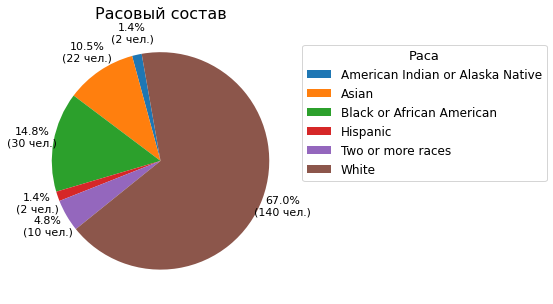

In [15]:
# Построим pie, отражающий распределение данных
plt.figure(figsize=(5,5))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} чел.)".format(pct, absolute)

wedges, texts, autotexts = plt.pie(race_counter['race_counter'], 
                                   autopct=lambda pct: func(pct, race_counter['race_counter']),
                                   pctdistance=1.2,
                                   startangle=100)
plt.title("Расовый состав", fontsize=16)

plt.legend(title='Раса', title_fontsize=13,
           labels=race_counter['race'], fontsize=12,
           bbox_to_anchor=(1, 0, 0, 0.95))
plt.setp(autotexts, size=11)
plt.show()

In [16]:
# Составим запрос, в котором посчитаем, сколько платят сотрудникам определенной расы в продакшене


cursor = conn.cursor()
sql_str = '''SELECT "Race Desc" AS race, 
                    "Pay"::money::numeric::float8 AS pay 
                    FROM production_staff 
                    WHERE "Race Desc" != 'None'
                    ORDER BY "Race Desc";'''

# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
race_pay_df = pd.read_sql_query(sql_str, conn)

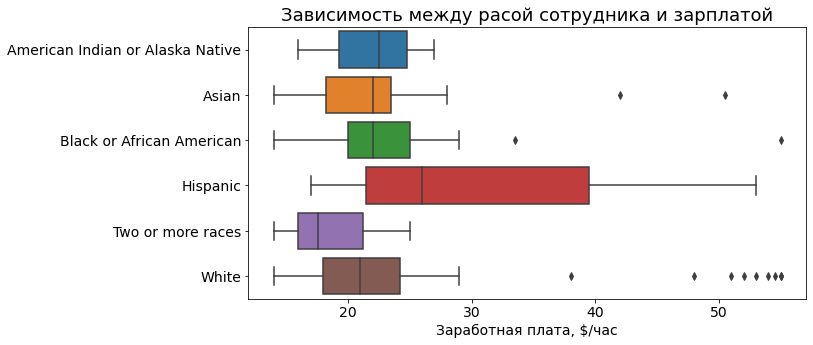

In [17]:
# Построим boxplot, отражающий распределение данных
plt.figure(figsize=(10,5))
plt.title("Зависимость между расой сотрудника и зарплатой", fontsize=18)
plt.xlabel('Заработная плата, $/час', fontsize=14)
plt.tick_params(labelsize=14)
sb.boxplot(x='pay', y='race', data=race_pay_df, orient='h').set(ylabel=None, xlabel='Заработная плата, $/час')
plt.show()

Выводы: 
* Латиноамериканские сотрудники зарабатывают больше представителей других рас. В свою очередь в продакшене работают только 3 представителя этой расы, что не дает оснований считать, что здесь присутствует расовая дискриминация.
* Азиаты и Афроамериканцы в среднем зарабатывают больше представителей белой расы, но их гораздо меньше в количественом отношении. Нужно проверить гипотезу, не связано ли это со стремлением работодателя удовлетворить желание современного общества на расовое разнообразие сотрудников и бОльшую оплату труда.

**6. Сколько человек числятся в базе данных под определенным трудовым статусом?**

In [13]:
# Предварительно составим запрос, в котором посчитаем, сколько людей работают под определенным статусом

cursor = conn.cursor()
sql_str = '''SELECT "Employment Status" AS employment_status, 
                    COUNT("Employment Status") AS employment_status_counter
                    FROM production_staff 
                    WHERE "Employment Status" != 'None'
                    GROUP BY "Employment Status"
                    ORDER BY "Employment Status";'''

# По результатам запроса сформируем датафрейм, который пригодится при визуализации данных
employment_status_df = pd.read_sql_query(sql_str, conn)   

In [14]:
employment_status_df

,employment_status,employment_status_counter
0,Active,107
1,Future Start,8
2,Leave of Absence,11
3,Terminated for Cause,8
4,Voluntarily Terminated,75


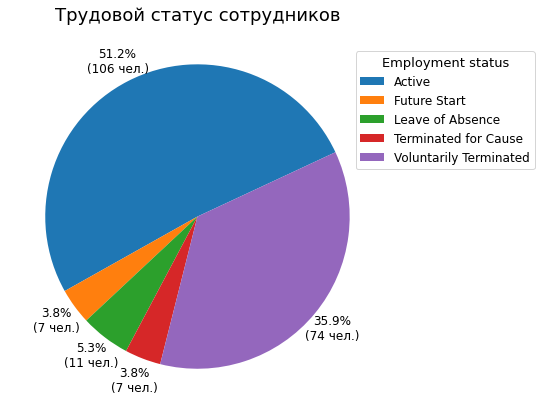

In [19]:
# Построим pie, отражающий распределение данных
plt.figure(figsize=(10,7))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} чел.)".format(pct, absolute)

wedges, texts, autotexts = plt.pie(employment_status_df['employment_status_counter'], 
                                   autopct=lambda pct: func(pct, employment_status_df['employment_status_counter']),
                                   pctdistance=1.15,
                                   startangle=25)

plt.title("Трудовой статус сотрудников", fontsize=18)

plt.legend(title='Employment status', title_fontsize=13,
           labels=employment_status_df['employment_status'], fontsize=12,
           bbox_to_anchor=(0.9, 0, 0, 0.95))
plt.setp(autotexts, size=12)
plt.show()

Вывод:
* В продакшене почти 36% людей уволились по собственному желанию. Нужно определить причину их увольнения, посмотреть performance score этих сотрудников и подумать, что можно сделать, чтобы высококвалифицированные сотрудники не увольнялись.
<br><br>Далее попытаемся определить причину увольнения сотрудников.

**7. Каковы официальные причины увольнения сотрудников?**

In [20]:
# Cоставим запрос, в котором посчитаем, сколько людей уволились по определенной причине

cursor = conn.cursor()
sql_str = '''SELECT "Reason for Term" AS term_reason,
                    COUNT("Reason for Term") AS term_reason_counter
                    FROM production_staff 
                    WHERE "Employment Status" = 'Voluntarily Terminated'
                    GROUP BY "Reason for Term"
                    ORDER BY term_reason_counter;'''

term_reason_df = pd.read_sql_query(sql_str, conn)   

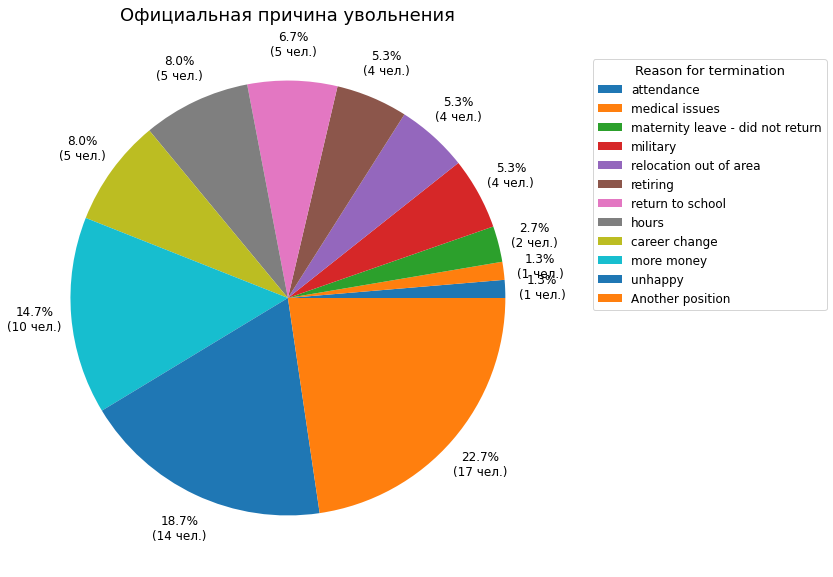

In [21]:
# Построим pie, отражающий распределение данных
plt.figure(figsize=(10,10))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} чел.)".format(pct, absolute)

wedges, texts, autotexts = plt.pie(term_reason_df['term_reason_counter'], 
                                   autopct=lambda pct: func(pct, term_reason_df['term_reason_counter']),
                                   pctdistance=1.17)

plt.title("Официальная причина увольнения", fontsize=18)

plt.legend(title='Reason for termination', title_fontsize=13,
           labels=term_reason_df['term_reason'], fontsize=12,
           bbox_to_anchor=(1.05, 0, 0, 0.95))
plt.setp(autotexts, size=12)
plt.show()

Вывод: Видим, что основными причинами увольнения были маленькая зарплата (**10 чел.**), несчастное эмоциональное состояние (14 чел.) и какие-то другие причины (**17 чел.**). Нужно поискать скрытые причины увольнения.

**8. Есть ли связь между performance score и причиной увольнения сотрудников?**

In [22]:
# Составим запрос, который покажет performance score сотрудников, которые уволились по собственному желанию

cursor = conn.cursor()
sql_str = '''SELECT "Performance Score" AS performance_score,
                    COUNT("Performance Score") AS performance_score_counter
                    FROM production_staff 
                    WHERE "Employment Status" = 'Voluntarily Terminated'
                    GROUP BY "Performance Score"
                    ORDER BY "Performance Score";'''

vt_performance_score_df = pd.read_sql_query(sql_str, conn)  

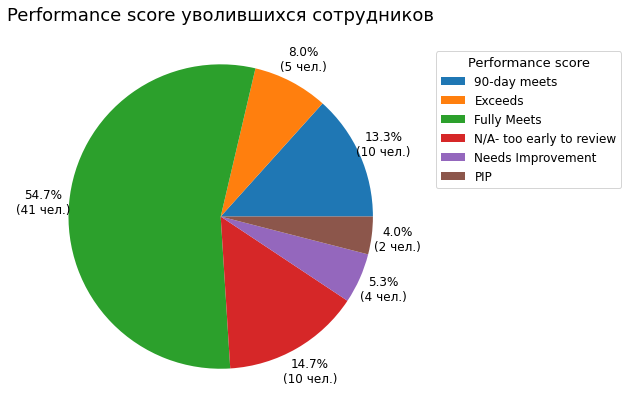

In [23]:
# Построим pie, отражающий распределение данных
plt.figure(figsize=(10,7))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} чел.)".format(pct, absolute)

wedges, texts, autotexts = plt.pie(vt_performance_score_df['performance_score_counter'], 
                                   autopct=lambda pct: func(pct, vt_performance_score_df['performance_score_counter']),
                                   pctdistance=1.17)
plt.title("Performance score уволившихся сотрудников", fontsize=18)
plt.legend(title='Performance score', title_fontsize=13,
           labels=vt_performance_score_df['performance_score'], fontsize=12,
           bbox_to_anchor=(1.05, 0, 0, 0.95))
plt.setp(autotexts, size=12)
plt.show()

Вывод: большинство уволившихся сотрудников имели хороший результат "performance score", данный фактор не влиял на увольнение сотрудников.

**9. Может ли уровень доходов стать причиной увольнения оставшихся сотрудников?**

In [24]:
# Составим запрос, который покажет уровень доходов сотрудников из двух категорий: Active и Voluntarily Terminated

cursor = conn.cursor()
sql_str = '''SELECT "Employment Status" AS employment_status, 
                    "Pay"::money::numeric::float8 AS pay
                    FROM production_staff 
                    WHERE "Employment Status" IN ('Active', 'Voluntarily Terminated')
                    ORDER BY "Employment Status";'''

active_and_vt_income_df = pd.read_sql_query(sql_str, conn)  

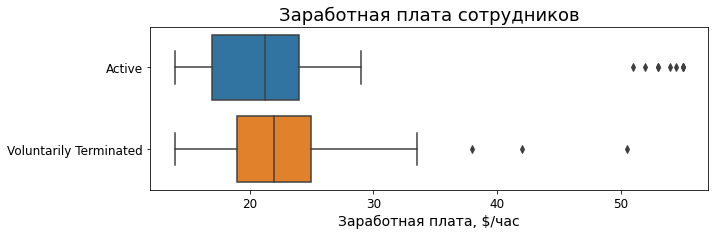

In [25]:
# Построим boxplot, отражающий распределение данных
plt.figure(figsize=(10,3))
plt.title('Заработная плата сотрудников', fontsize=18)
plt.xlabel('Заработная плата, $/час', fontsize=14)
plt.tick_params(labelsize=12)
sb.boxplot(x='pay', y='employment_status', data=active_and_vt_income_df, orient='h')\
    .set(ylabel=None, xlabel='Заработная плата, $/час')
plt.show()

Вывод: Видим, что текущая зарплата у активных сотрудников по большей мере ниже, чем у уволившихся. Велик риск увольнения оставшихся сотрудников.

**10. Могла ли продолжительность работы в компании стать причиной увольнения сотрудников?**

In [26]:
# Составим запрос, который покажет продолжительность работы сотрудников из двух категорий: Active и Voluntarily Terminated

cursor = conn.cursor()
sql_str = '''SELECT production_staff."Employment Status" AS employment_status, 
                    hr_dataset."Days Employed" AS days_employed
                    FROM production_staff
                    JOIN hr_dataset
                    ON production_staff."Employee Name" = hr_dataset."Employee Name"
                    WHERE production_staff."Employment Status" IN ('Active', 'Voluntarily Terminated')
                    ORDER BY production_staff."Employment Status";'''

active_and_vt_days_employed_df = pd.read_sql_query(sql_str, conn)

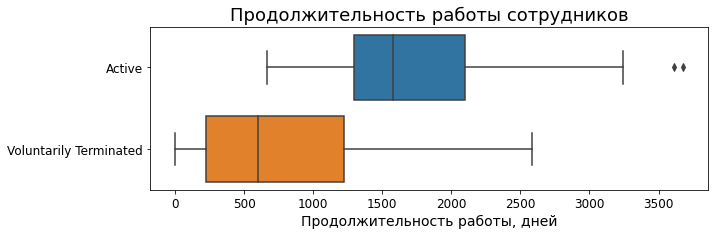

In [27]:
# Построим boxplot, отражающий распределение данных
plt.figure(figsize=(10,3))
plt.title('Продолжительность работы сотрудников', fontsize=18)
plt.xlabel('Продолжительность работы, дней', fontsize=14)
plt.tick_params(labelsize=12)
sb.boxplot(x='days_employed', y='employment_status', data=active_and_vt_days_employed_df, orient='h')\
    .set(ylabel=None, xlabel='Продолжительность работы, дней')
plt.show()

Вывод: Видим, что медианная продолжительность работы уволившихся сотрудников почти в 3 раза меньше, чем у сотрудников, которые до сих пор работают.

**11. Связано ли увольнение сотрудников с полом?**

In [28]:
# Составим запрос, который посчитает количество сотрудников определенного пола в двух категорияъ: 
# Active и Voluntarily Terminated

cursor = conn.cursor()
sql_str = '''SELECT production_staff."Employment Status" AS employment_status, 
                    hr_dataset.sex AS gender,
                    COUNT(hr_dataset.sex) AS gender_counter
                    FROM production_staff
                    JOIN hr_dataset
                    ON production_staff."Employee Name" = hr_dataset."Employee Name"
                    WHERE production_staff."Employment Status" IN ('Active', 'Voluntarily Terminated')
                    GROUP BY production_staff."Employment Status", hr_dataset.sex
                    ORDER BY production_staff."Employment Status";'''

gender_df = pd.read_sql_query(sql_str, conn)
gender_df = gender_df.groupby('employment_status')

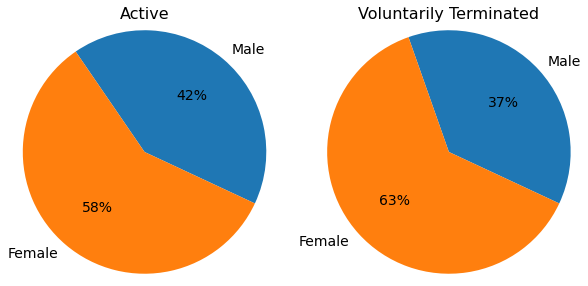

In [29]:
# Построим pie, отражающий распределение данных
f, ax = plt.subplots(1,2, figsize=(10,5))

for ax, group in zip(ax.ravel(), list(gender_df.groups.keys())):
    current_group = gender_df.get_group(group)
    ax.pie(current_group['gender_counter'], 
           labels=current_group['gender'],
           autopct='%1.0f%%', 
           radius=1.2, 
           textprops=dict(fontsize=14),
           startangle=-25)
    ax.set_title(group, fontsize=16)
    ax.set()
plt.show()

Вывод: Видим, что гендерный состав уволившихся сотрудников приблизительно совпадает с гендерным составом текущих сотрудников.

**12. Мог ли руководитель стать причиной увольнения сотрудника?**

In [30]:
# Составим запрос, который посчитает количество уволившихся сотрудников у определенного руководителя

cursor = conn.cursor()
sql_str = '''SELECT hr_dataset."Manager Name" AS manager_name, 
                    COUNT(production_staff."Employment Status") AS employment_status_counter
                    FROM production_staff
                    JOIN hr_dataset
                    ON production_staff."Employee Name" = hr_dataset."Employee Name"
                    WHERE production_staff."Employment Status" = 'Voluntarily Terminated'
                    GROUP BY hr_dataset."Manager Name", production_staff."Employment Status"
                    ORDER BY hr_dataset."Manager Name";'''

manager_employment_status_df = pd.read_sql_query(sql_str, conn)

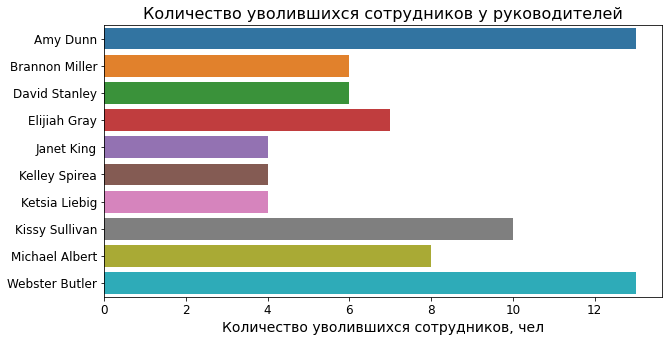

In [31]:
# Построим boxplot, отражающий распределение данных
plt.figure(figsize=(10,5))
plt.title('Количество уволившихся сотрудников у руководителей', fontsize=16)
plt.xlabel('Количество уволившихся сотрудников, чел', fontsize=14)
plt.tick_params(labelsize=12)
sb.barplot(x='employment_status_counter', y='manager_name', data=manager_employment_status_df, orient='h')\
    .set(ylabel=None, xlabel='Количество уволившихся сотрудников, чел')
plt.show()

Общий вывод по текущим сотрудникам:
* В компании присутствует проблема текучести кадров, почти **36%** сотрудников из продакшн отдела уволились по собственному желанию. Половина уволившихся сотрудников проработали в компании менее 2-х лет. При этом по показателю `performance score` можно сказать, что эти сотрудники были достаточно эффективны. Основными причинами увольнения были маленькая зарплата (**10 чел.**), несчастное эмоциональное состояние (14 чел.) и неуказанные причины (**17 чел.**).
* Уровень оплаты труда текущих сотрудников ниже, чем у тех, что уволились, а продолжительность работы в 3 раза выше. Следует оценить необходимость повышения уровня оплаты труда, провести исследование удовлетворенности сотрудников своим положением.
* Присутствует разница в загрузке и эффективности руководства отдельных менеджеров. Следует рассмотреть увеличение загрузки отдельных менеджеров, повысить до должности руководителя отдельных особо успешных работников и разгрузить текущих менеджеров. Также можно финансово поощрить отдельных руководителей.
* Есть руководители, у которых большое количество уволившихся сотрудников, есть руководители, у которых увольнений вообще нет. Следует выявить причины такой закономерности, провести беседу с конкретными руководителями. Возможно, руководитель является истинной причиной увольнения сотрудников.